In [1]:
import pandas as pd 
import numpy as np 

train_df = pd.read_csv('../data/processed/train.csv')
test_df = pd.read_csv('../data/processed/test.csv')
val_df = pd.read_csv('../data/processed/val.csv')

In [2]:
train_df.isna().sum()

year                           0
population                     0
gdp                            0
primary_energy_consumption     0
oil_co2                        0
coal_co2                       0
cement_co2                     0
total_ghg                      0
co2_including_luc              0
temperature_change_from_ghg    0
co2                            0
country                        0
dtype: int64

In [3]:
test_df.isna().sum()

year                           0
population                     0
gdp                            0
primary_energy_consumption     0
oil_co2                        0
coal_co2                       0
cement_co2                     0
total_ghg                      0
co2_including_luc              0
temperature_change_from_ghg    0
co2                            0
country                        0
dtype: int64

In [4]:
val_df.isna().sum()

year                           0
population                     0
gdp                            0
primary_energy_consumption     0
oil_co2                        0
coal_co2                       0
cement_co2                     0
total_ghg                      0
co2_including_luc              0
temperature_change_from_ghg    0
co2                            0
country                        0
dtype: int64

In [5]:
feature_cols = [
    'population', 'gdp', 'primary_energy_consumption',
    'oil_co2', 'coal_co2', 'cement_co2',
    'total_ghg', 'co2_including_luc',
    'temperature_change_from_ghg'
]

target_col = ['co2']


In [6]:
log_transform_cols = [
    'population', 'gdp', 'primary_energy_consumption',
    'oil_co2', 'coal_co2', 'cement_co2',
    'total_ghg', 'co2_including_luc', 'co2']

for col in log_transform_cols:
    train_df[col] = np.log1p(train_df[col])
    val_df[col] = np.log1p(val_df[col])
    test_df[col] = np.log1p(test_df[col])


/home/aic/anaconda3/envs/aic/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [7]:
test_df

,year,population,gdp,primary_energy_consumption,oil_co2,coal_co2,cement_co2,total_ghg,co2_including_luc,temperature_change_from_ghg,co2,country
0,1950,16.832437,23.984979,3.456537,0.603222,0.043059,0.080658,5.192712,5.415531,0.003,0.670902,Thailand
1,1951,16.858374,24.053467,3.456537,0.636577,0.046884,0.142367,5.207145,5.417566,0.003,0.737642,Thailand
2,1952,16.884846,24.107175,3.456537,0.741937,0.053541,0.116004,5.238721,5.452282,0.003,0.823298,Thailand
3,1953,16.911510,24.211454,3.456537,0.876718,0.094401,0.132781,5.266925,5.471001,0.004,0.972293,Thailand
4,1954,16.938463,24.203342,3.456537,0.976445,0.187309,0.173113,5.292013,5.497705,0.004,1.115142,Thailand
...,...,...,...,...,...,...,...,...,...,...,...,...
69,2019,18.085519,27.770027,7.300301,4.650641,4.263525,3.148625,6.078875,5.768705,0.015,5.645012,Thailand
70,2020,18.087185,27.706437,7.227487,4.577922,4.328085,3.132272,6.055357,5.731297,0.015,5.609190,Thailand
71,2021,18.088383,27.721946,7.235482,4.520919,4.352186,3.097883,6.045164,5.713277,0.015,5.591517,Thailand
72,2022,18.088494,27.748043,7.236262,4.671220,4.259986,3.090815,6.057533,5.728033,0.015,5.611568,Thailand


In [8]:
X_train = train_df[feature_cols]
y_train = train_df[target_col]

X_val = val_df[feature_cols]
y_val = val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]


In [9]:
from sklearn.preprocessing import StandardScaler

feature_scaler = StandardScaler()
target_scaler = StandardScaler()

X_train_scaled = feature_scaler.fit_transform(X_train)
X_val_scaled = feature_scaler.transform(X_val)
X_test_scaled = feature_scaler.transform(X_test)

y_train_scaled = target_scaler.fit_transform(y_train)
y_val_scaled = target_scaler.transform(y_val)
y_test_scaled = target_scaler.transform(y_test)


In [10]:
import joblib

joblib.dump(feature_scaler, 'feature_scaler.pkl')
joblib.dump(target_scaler, 'target_scaler.pkl')

['target_scaler.pkl']

In [11]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# === Train XGBoost ===
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

xgb_model.fit(X_train_scaled, y_train_scaled.ravel())  

# === Predict on Validation Set ===
y_val_pred_scaled = xgb_model.predict(X_val_scaled)

# === Inverse Transform: scaled → log → real-world CO₂ ===
y_val_pred_log = target_scaler.inverse_transform(y_val_pred_scaled.reshape(-1, 1))
y_val_pred_real = np.expm1(y_val_pred_log)

# === Prepare Ground Truth for Comparison ===
y_val_log = target_scaler.inverse_transform(y_val_scaled)
y_val_real = np.expm1(y_val_log)

# === Evaluation Metrics ===
mse = mean_squared_error(y_val_real, y_val_pred_real)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_val_real, y_val_pred_real)
r2 = r2_score(y_val_real, y_val_pred_real)

print(f"XGBoost Validation Performance:")
print(f"• MSE  = {mse:.2f}")
print(f"• RMSE = {rmse:.2f}")
print(f"• MAE  = {mae:.2f}")
print(f"• R²   = {r2:.4f}")


XGBoost Validation Performance:
• MSE  = 124.85
• RMSE = 11.17
• MAE  = 4.14
• R²   = 0.9906


In [12]:
y_test_pred_scaled = xgb_model.predict(X_test_scaled)

# Inverse transform predictions
y_test_pred_log = target_scaler.inverse_transform(y_test_pred_scaled.reshape(-1, 1))
y_test_pred_real = np.expm1(y_test_pred_log)

# Inverse transform ground truth
y_test_log = target_scaler.inverse_transform(y_test_scaled)
y_test_real = np.expm1(y_test_log)

# === Evaluation Metrics ===
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse_test = mean_squared_error(y_test_real, y_test_pred_real)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_real, y_test_pred_real)
r2_test = r2_score(y_test_real, y_test_pred_real)

print(f"XGBoost Test Performance:")
print(f"• MSE  = {mse_test:.2f}")
print(f"• RMSE = {rmse_test:.2f}")
print(f"• MAE  = {mae_test:.2f}")
print(f"• R²   = {r2_test:.4f}")


XGBoost Test Performance:
• MSE  = 315.80
• RMSE = 17.77
• MAE  = 10.22
• R²   = 0.9707


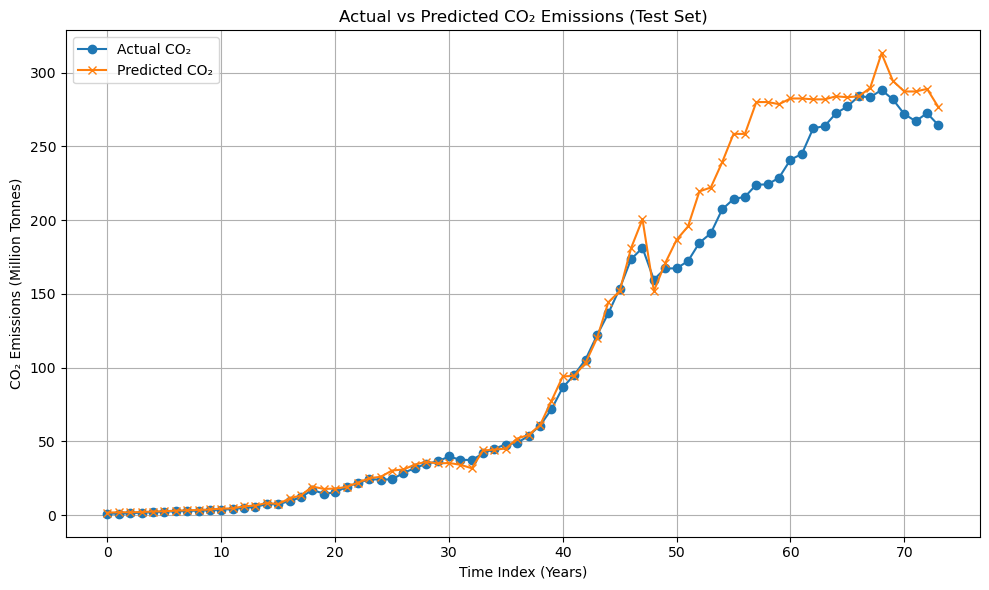

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_real, label="Actual CO₂", marker='o')
plt.plot(y_test_pred_real, label="Predicted CO₂", marker='x')
plt.title("Actual vs Predicted CO₂ Emissions (Test Set)")
plt.xlabel("Time Index (Years)")
plt.ylabel("CO₂ Emissions (Million Tonnes)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
import joblib

# Example: Save XGBoost model
joblib.dump(xgb_model, "xgb_model.pkl")


['xgb_model.pkl']

In [15]:
xgb_model = joblib.load("xgb_model.pkl")

In [16]:
import pandas as pd
import numpy as np

# Define the unseen 2023 input
data_2023 = {
    'year': [2023],
    'population': [71702438.0],
    'gdp': [1124143726592.0],
    'primary_energy_consumption': [1390.812],
    'oil_co2': [104.343],
    'coal_co2': [59.327],
    'cement_co2': [19.248],
    'total_ghg': [416.852],
    'co2_including_luc': [297.369],
    'temperature_change_from_ghg': [0.015],
    'co2': [264.389], 
    'country': ['Thailand']
}

df_2023 = pd.DataFrame(data_2023)

# === Step 1: Log transform the relevant raw columns ===
log_transform_cols = [
    'population', 'gdp', 'primary_energy_consumption',
    'oil_co2', 'coal_co2', 'cement_co2',
    'total_ghg', 'co2_including_luc'
]

for col in log_transform_cols:
    df_2023[col] = np.log1p(df_2023[col])

feature_cols = [
    "population", "gdp", "primary_energy_consumption",
    "oil_co2", "coal_co2", "cement_co2",
    "total_ghg", "co2_including_luc",
    "temperature_change_from_ghg"
]

X_2023 = df_2023[feature_cols]

# === Step 3: Scale the input using the trained scaler ===
X_2023_scaled = feature_scaler.transform(X_2023)

# === Step 4: Predict using XGBoost model ===
y_2023_pred_scaled = xgb_model.predict(X_2023_scaled)

# === Step 5: Inverse transform the prediction and undo log1p ===
y_2023_pred_log = target_scaler.inverse_transform(y_2023_pred_scaled.reshape(-1, 1))
y_2023_pred_real = np.expm1(y_2023_pred_log)

print(f"Predicted CO₂ emissions for Thailand in 2023: {y_2023_pred_real[0][0]:,.2f} million tonnes")


Predicted CO₂ emissions for Thailand in 2023: 276.58 million tonnes


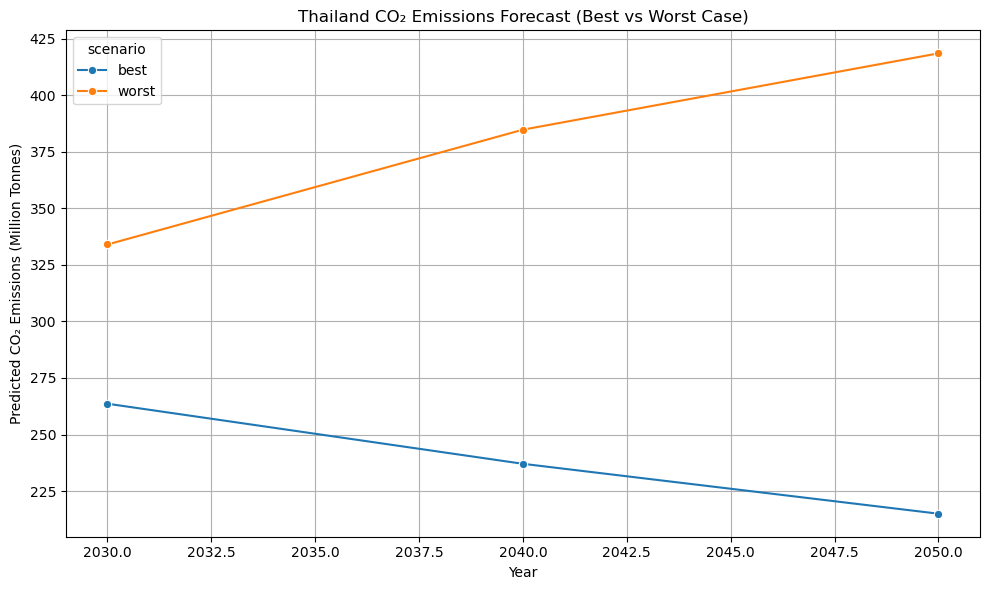

   year scenario  predicted_co2
0  2030     best     263.621490
1  2030    worst     334.018616
2  2040     best     237.052963
3  2040    worst     384.778778
4  2050     best     214.992599
5  2050    worst     418.525757


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
from xgboost import XGBRegressor

# Load saved scalers and model
feature_scaler = joblib.load("feature_scaler.pkl")
target_scaler = joblib.load("target_scaler.pkl")
xgb_model = joblib.load("xgb_model.pkl")

# Define future scenarios for Thailand
scenario_data = {
    "year": [2030, 2030, 2040, 2040, 2050, 2050],
    "scenario": ["best", "worst", "best", "worst", "best", "worst"],
    "population": [72000000, 75000000, 73000000, 76000000, 74000000, 77000000],
    "gdp": [1.4e12, 1.6e12, 1.8e12, 2.0e12, 2.1e12, 2.4e12],
    "primary_energy_consumption": [1450, 1700, 1500, 2000, 1550, 2200],
    "oil_co2": [85, 120, 60, 140, 50, 150],
    "coal_co2": [45, 85, 35, 100, 30, 120],
    "cement_co2": [15, 20, 12, 25, 10, 30],
    "total_ghg": [380, 450, 360, 500, 340, 550],
    "co2_including_luc": [250, 300, 220, 330, 200, 360],
    "temperature_change_from_ghg": [0.02, 0.03, 0.025, 0.035, 0.03, 0.04],
}

# Create DataFrame
scenarios_df = pd.DataFrame(scenario_data)

# Log-transform raw features (but NOT ratios)
log_transform_cols = [
    "population", "gdp", "primary_energy_consumption",
    "oil_co2", "coal_co2", "cement_co2",
    "total_ghg", "co2_including_luc"
]
for col in log_transform_cols:
    scenarios_df[col] = np.log1p(scenarios_df[col])

# Feature columns used by model
feature_cols = log_transform_cols + ["temperature_change_from_ghg"]

# Scale and predict
X_scenarios = scenarios_df[feature_cols]
X_scenarios_scaled = feature_scaler.transform(X_scenarios)
y_scenarios_scaled = xgb_model.predict(X_scenarios_scaled)
y_scenarios_log = target_scaler.inverse_transform(y_scenarios_scaled.reshape(-1, 1))
y_scenarios_real = np.expm1(y_scenarios_log)

# Add predictions
scenarios_df["predicted_co2"] = y_scenarios_real

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=scenarios_df, x="year", y="predicted_co2", hue="scenario", marker="o")
plt.title("Thailand CO₂ Emissions Forecast (Best vs Worst Case)")
plt.ylabel("Predicted CO₂ Emissions (Million Tonnes)")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.show()

# Output final comparison
print(scenarios_df[["year", "scenario", "predicted_co2"]])


“We found that increasing GDP and population while holding fossil fuel-related CO₂ emissions constant led the model to predict lower overall CO₂ emissions. This suggests that the model implicitly learned that higher economic output or population, without proportional increases in emissions, indicates improved efficiency.”

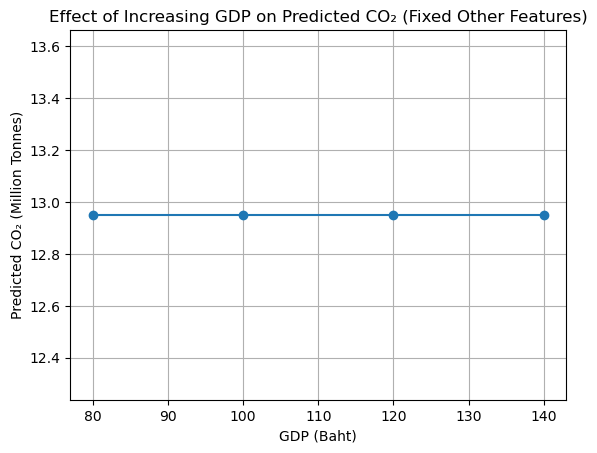

In [19]:
import matplotlib.pyplot as plt

oil_values = [80, 100, 120, 140]

predictions = []

for gdp in oil_values:
    test_df = df_2023.copy()
    test_df["gdp"] = gdp
    test_df[log_transform_cols] = test_df[log_transform_cols].apply(np.log1p)
    scaled = feature_scaler.transform(test_df[feature_cols])
    pred_scaled = xgb_model.predict(scaled)
    pred_log = target_scaler.inverse_transform(pred_scaled.reshape(-1, 1))
    predictions.append(np.expm1(pred_log[0][0]))

plt.plot(oil_values, predictions, marker='o')
plt.xlabel("GDP (Baht)")
plt.ylabel("Predicted CO₂ (Million Tonnes)")
plt.title("Effect of Increasing GDP on Predicted CO₂ (Fixed Other Features)")
plt.grid(True)
plt.show()


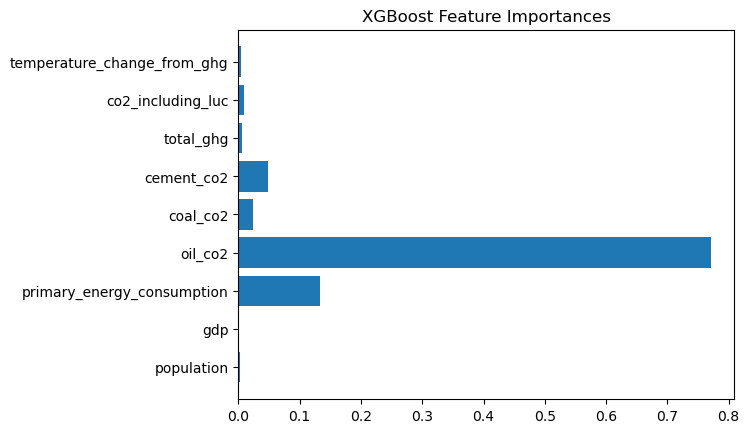

In [20]:
import matplotlib.pyplot as plt

importances = xgb_model.feature_importances_
plt.barh(feature_cols, importances)
plt.title("XGBoost Feature Importances")
plt.show()


The model learns statistical patterns, not causality. While higher GDP often correlates with energy efficiency, CO₂ emissions should not decrease without actual reduction in fossil fuel usage.”

“Future work should include engineered features like co2_per_gdp, co2_per_capita, or even integrate external efficiency metrics.”

oil_co2 is dominant	Focus policy simulations on reducing oil-related emissions

In [21]:
import pandas as pd
import numpy as np

# Step 1: Base 2023 input data
base_input = {
    'year': [2023],
    'population': [71702438.0],
    'gdp': [1.1e12],  # Will override per scenario
    'primary_energy_consumption': [1390.812],
    'oil_co2': [104],  # Will override per scenario
    'coal_co2': [59.327],
    'cement_co2': [19.248],
    'total_ghg': [416.852],
    'co2_including_luc': [297.369],
    'temperature_change_from_ghg': [0.015],
}

# Step 2: Scenario definitions
scenarios = [
    {"name": "Base Case", "gdp": 1.1e12, "coal_co2": 59},
    {"name": "High GDP (↑ Efficiency)", "gdp": 1.6e12, "coal_co2": 49},
    {"name": "Higher Fuel Emissions", "gdp": 1.6e12, "coal_co2": 70},
]

# Make sure this matches what your model was trained on
log_transform_cols = [
    "population", "gdp", "primary_energy_consumption",
    "oil_co2", "coal_co2", "cement_co2",
    "total_ghg", "co2_including_luc"
]

feature_cols = log_transform_cols + ["temperature_change_from_ghg"]

# Step 3: Run scenarios
results = []

for scenario in scenarios:
    df = pd.DataFrame(base_input)

    # Apply overrides
    df.loc[0, "gdp"] = scenario["gdp"]
    df.loc[0, "coal_co2"] = scenario["coal_co2"]

    # Apply log transform
    for col in log_transform_cols:
        df[col] = np.log1p(df[col])

    # Scale features
    X = df[feature_cols]
    X_scaled = feature_scaler.transform(X)

    # Predict and inverse transform
    y_scaled = xgb_model.predict(X_scaled)
    y_log = target_scaler.inverse_transform(y_scaled.reshape(-1, 1))
    y_real = np.expm1(y_log)[0][0]

    results.append({
        "Scenario": scenario["name"],
        "GDP (THB Trillion)": round(scenario["gdp"] / 1e12, 2),
        "Oil CO₂ (Mt)": scenario["coal_co2"],
        "Predicted CO₂ (Mt)": round(y_real, 2)
    })

# Step 4: Display the results
result_df = pd.DataFrame(results)
print(result_df)


                  Scenario  GDP (THB Trillion)  Oil CO₂ (Mt)  \
0                Base Case                 1.1            59   
1  High GDP (↑ Efficiency)                 1.6            49   
2    Higher Fuel Emissions                 1.6            70   

   Predicted CO₂ (Mt)  
0          276.579987  
1          276.579987  
2          277.739990  
